In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from patsy import dmatrices
import statsmodels.api as sm
from utilities import *

In [2]:
# importing the feature file
path= './'
file= 'SegmentFeatures2.csv'
data= pd.read_csv(path+file, delimiter=',')
display(data.head())

,SegmentId,RecordNum,StartingTime,RRBreach,SpO2Breach,RRHighRegions,SpO2LowRegions,Stage1OccurL,Stage2OccurL,Stage3OccurL,RRUnsafeRegions,SpO2UnsafeRegions,Stage1OccurH,Stage2OccurH,Stage3OccurH,FeatureSum,Type1Pattern
0,Seg0,3861446,30.0,0,0,0,0,2,0,1,12,7,1,0,0,23,1
1,Seg1,3861446,31.0,0,0,0,0,3,0,1,12,7,1,0,0,24,1
2,Seg2,3861446,32.0,0,0,0,0,2,0,1,12,6,1,0,0,22,1
3,Seg3,3861446,4.0,0,1,0,1,5,1,1,2,3,0,0,0,14,1
4,Seg4,3861446,8.0,0,1,0,1,4,1,1,4,4,1,0,0,17,1


In [3]:
X=data[['RRBreach', 'SpO2Breach',
       'RRHighRegions', 'SpO2LowRegions', 'Stage1OccurL', 'Stage2OccurL',
       'Stage3OccurL', 'RRUnsafeRegions', 'SpO2UnsafeRegions', 'Stage1OccurH',
       'Stage2OccurH', 'Stage3OccurH']]
X.head()

,RRBreach,SpO2Breach,RRHighRegions,SpO2LowRegions,Stage1OccurL,Stage2OccurL,Stage3OccurL,RRUnsafeRegions,SpO2UnsafeRegions,Stage1OccurH,Stage2OccurH,Stage3OccurH
0,0,0,0,0,2,0,1,12,7,1,0,0
1,0,0,0,0,3,0,1,12,7,1,0,0
2,0,0,0,0,2,0,1,12,6,1,0,0
3,0,1,0,1,5,1,1,2,3,0,0,0
4,0,1,0,1,4,1,1,4,4,1,0,0


In [4]:
Y=data[['Type1Pattern']]
Y.head()

,Type1Pattern
0,1
1,1
2,1
3,1
4,1


In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/4,random_state = 10)
display(y_test['Type1Pattern'].value_counts(normalize=True) * 100)
display(y_train['Type1Pattern'].value_counts(normalize=True) * 100)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print(np.shape(y_train))
print(np.shape(y_test))

0    51.851852
1    48.148148
Name: Type1Pattern, dtype: float64

1    50.353357
0    49.646643
Name: Type1Pattern, dtype: float64

(1132,)
(378,)


In [6]:
import lightgbm as lgb
# Get default hyperparameters
model_lgb = lgb.LGBMClassifier()
default_params = model_lgb.get_params()
display(default_params)

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [7]:
model_lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

[[182  14]
 [ 14 168]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       196
           1       0.92      0.92      0.92       182

    accuracy                           0.93       378
   macro avg       0.93      0.93      0.93       378
weighted avg       0.93      0.93      0.93       378



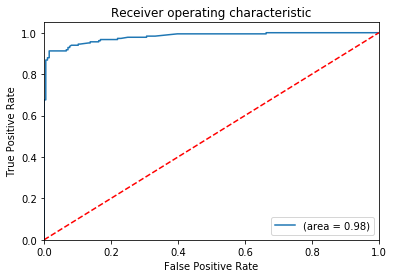

0.7544250923059577

Model Classification stats with Optimal Threshold
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       196
           1       0.98      0.91      0.94       182

    accuracy                           0.95       378
   macro avg       0.95      0.95      0.95       378
weighted avg       0.95      0.95      0.95       378



,Value
accuracy,0.947090
recall,0.906593
precision,0.982143
f1-score,0.942857
roc_auc_score,0.980741


In [8]:
metrics_analysis(X_test,y_test,model_lgb)
optimal_threshold=plot_rocauc(X_test,y_test,model_lgb)
print('Model Classification stats with Optimal Threshold')
display_classification_metrics(X_test,y_test,model_lgb,optimal_threshold)

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 50)),
    'learning_rate': list(np.logspace(np.log10(0.01), np.log10(0.5), base = 10, num = 100)),
    'n_estimators': list(range(2,20))
}

#display(param_grid['learning_rate'])
#display(len(param_grid['learning_rate']))

# Grid search cross validation
grid = GridSearchCV(lgb.LGBMClassifier(random_state=10),param_grid,n_jobs=-1, verbose=1, cv=5)
model_lgb_grid = grid.fit(X_train,y_train)

Fitting 5 folds for each of 162000 candidates, totalling 810000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2748 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 5548 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 9148 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 13548 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 18748 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 24748 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 31548 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 39148 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 47548 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 56748 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 66748 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 77548 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 89148 

In [10]:
print(model_lgb_grid.best_params_)

{'boosting_type': 'gbdt', 'learning_rate': 0.36448486475346364, 'n_estimators': 19, 'num_leaves': 31}


[[184  12]
 [ 14 168]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       196
           1       0.93      0.92      0.93       182

    accuracy                           0.93       378
   macro avg       0.93      0.93      0.93       378
weighted avg       0.93      0.93      0.93       378



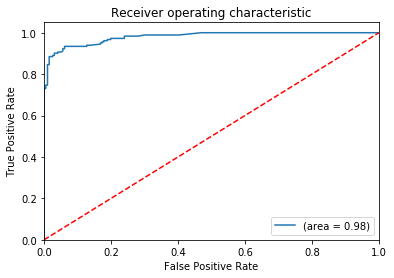

0.47756389878985145

Model Classification stats with Optimal Threshold
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       196
           1       0.93      0.93      0.93       182

    accuracy                           0.93       378
   macro avg       0.93      0.93      0.93       378
weighted avg       0.93      0.93      0.93       378



,Value
accuracy,0.933862
recall,0.928571
precision,0.933702
f1-score,0.931129
roc_auc_score,0.980475


In [11]:
model_lgb_best_param=lgb.LGBMClassifier(boosting_type ='gbdt',
 learning_rate= 0.36448486475346364,
 n_estimators= 19,
 num_leaves= 31)

model_lgb_best_param.fit(X_train,y_train)
metrics_analysis(X_test,y_test,model_lgb_best_param)
optimal_threshold=plot_rocauc(X_test,y_test,model_lgb_best_param)
print('Model Classification stats with Optimal Threshold')
display_classification_metrics(X_test,y_test,model_lgb_best_param,optimal_threshold)

### -------------------Final Model-----------------------------
##### Splitting into training and testing
##### Training : 0:500 = 500
##### Training : 752:1252 = 500
##### Test: 500:752  = 252
##### Test: 1252:1510 = 258

In [12]:
# importing the feature file
datafile_path= './'
datafile_name= 'SegmentFeatures2.csv'
data= pd.read_csv(datafile_path+datafile_name, delimiter=',')
X=data[['RRBreach', 'SpO2Breach',
       'RRHighRegions', 'SpO2LowRegions', 'Stage1OccurL', 'Stage2OccurL',
       'Stage3OccurL', 'RRUnsafeRegions', 'SpO2UnsafeRegions', 'Stage1OccurH',
       'Stage2OccurH', 'Stage3OccurH']]
Y=data[['Type1Pattern']]
X_TRAIN = np.concatenate((X.values[0:500,:],X.values[752:1252,:]),axis=0)
Y_TRAIN = np.concatenate((Y.values[0:500],Y.values[752:1252]),axis=0)
Y_TRAIN = Y_TRAIN.ravel()

X_TEST = np.concatenate((X.values[500:752,:],X.values[1252:1510,:]),axis=0)
Y_TEST = np.concatenate((Y.values[500:752],Y.values[1252:1510]),axis=0)
Y_TEST = Y_TEST.ravel()
print(np.shape(X_TRAIN))
print(np.shape(Y_TRAIN))
print(np.shape(X_TEST))
print(np.shape(Y_TEST))


(1000, 12)
(1000,)
(510, 12)
(510,)


[[230  28]
 [ 19 233]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       258
           1       0.89      0.92      0.91       252

    accuracy                           0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510



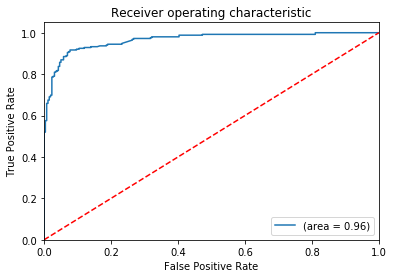

0.6870946133970928

Model Classification stats with Optimal Threshold
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       258
           1       0.92      0.91      0.92       252

    accuracy                           0.92       510
   macro avg       0.92      0.92      0.92       510
weighted avg       0.92      0.92      0.92       510



,Value
accuracy,0.917647
recall,0.912698
precision,0.920000
f1-score,0.916335
roc_auc_score,0.964962


In [13]:
model_lgb_best_param=lgb.LGBMClassifier(boosting_type ='gbdt',
 learning_rate= 0.36448486475346364,
 n_estimators= 19,
 num_leaves= 31)

model_lgb_best_param.fit(X_TRAIN, Y_TRAIN)
metrics_analysis(X_TEST,Y_TEST, model_lgb_best_param)
optimal_threshold=plot_rocauc(X_TEST,Y_TEST, model_lgb_best_param)
print('Model Classification stats with Optimal Threshold')
display_classification_metrics(X_TEST,Y_TEST, model_lgb_best_param, optimal_threshold)

### Saving the model

In [14]:
import pickle
# save the model to disk
model_path= './'
model_name = 'lgb_model.sav'
pickle.dump(model_lgb_best_param, open(model_path+model_name, 'wb'))